<a href="https://colab.research.google.com/github/kszymon/Neural-Network-Pytorch/blob/main/konv_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import torch
import torchvision
import torch.nn as nn

In [17]:
n_epochs = 3
batch_size = 64
batch_size_test = 1000
learning_rate = 0.01
log_interval = 10
random_seed = 123

In [18]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_of_devices = torch.cuda.device_count()
print(f' num of devices {num_of_devices}')
if torch.cuda.is_available():
    print(f' device name is {torch.cuda.get_device_name()}')
else:
    print(' No CUDA device available.')

 num of devices 0
 No CUDA device available.


In [19]:
# ładuje cyfry MNIST
std = (0.3081, )
mu = (0.1307, )

# używam dataloader
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                  torchvision.transforms.ToTensor(),
                                  torchvision.transforms.Normalize(
                                      mu, std
                                  )
                                ])),
    batch_size=batch_size, shuffle=True)

# test loader
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       mu, std
                                   )
                               ])),
    batch_size=batch_size_test, shuffle=False)

In [20]:
# sprawdzam dostep do danych

data, target = next(iter(train_loader))
print(f'data shape is {data.shape}')
print(f'shape of target is {target.shape}')

data shape is torch.Size([64, 1, 28, 28])
shape of target is torch.Size([64])


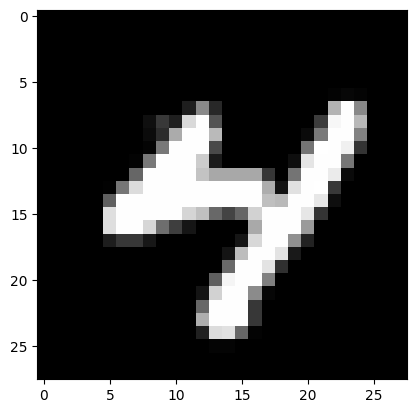

In [21]:
from matplotlib import pyplot as pyplot
pyplot.imshow(next(iter(train_loader))[0][5, 0, :, :], cmap='gray')

In [22]:
# implementacja klasyfikatora

import torch.nn.functional as F
class Network(nn.Module):
  def __init__(self):
    super(Network, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)

    # regulzaryzacja
    self.conv2_drop = nn.Dropout2d()

    # warstwy liniowe
    self.linear1 = nn.Linear(320, 50)
    self.linear2 = nn.Linear(50, 10)

    # funkcja przetwarzania danych w przód:
  def forward(self, x):

    #print(f'x shape at 0 {x.shape}')

    x  = self.conv1(x)
    #print(f'shape of x after conv1 {x.shape}')

    # max pooling
    x = F.max_pool2d(x, kernel_size=2)

    #print(f'x shape after first pooling {x.shape}')

    # aktywacja
    x = F.relu(x)
    #print(f'x shape after activation {x.shape}')

    x = self.conv2(x)
    #print(f'shape of x after conv {x.shape}')

    # max pooling
    x = F.max_pool2d(x, kernel_size=2)

    #print(f'x shape after max pooling {x.shape}')

    x = F.relu(x)

    # reshaping
    x = x.view(-1, 320)

    # first linear
    x = self.linear1(x)
    #print(f'shape of x after first linear {x.shape}')

    x = F.relu(x)

    # regularyzacja linear
    x = F.dropout(x, training=self.training)

    #print(f'shape of x after dropout {x.shape}')

    # second linear
    x = self.linear2(x)

    #print(f'x after second linear {x.shape}')

    return F.log_softmax(x, dim=1)

In [23]:
a = next(iter(train_loader))
print(a[0].shape)
print(type(a[0]))

torch.Size([64, 1, 28, 28])
<class 'torch.Tensor'>


In [24]:
model = Network()
out = model(a[0])

print(f'output shape is {out.shape}')

output shape is torch.Size([64, 10])


In [25]:
# optymlizer
optimizer = torch.optim.Adam(params = model.parameters(), lr=learning_rate)

In [26]:
# do wizualizacji postepów uczenia
train_losses = []
train_counter = []
test_losses = []
test_counter = [i * len(train_loader.dataset) for i in range(n_epochs + 1)]

In [27]:
# training
def train_single_epoch(epoch, model, optimizer, train_loader, loss_fcn):

    model.train()

    for batch_ind, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()

        # przetwarzanie do przodu
        output = model(data)

        # obliczenia funkcji kosztu
        loss = F.nll_loss(output, target)

        # back propagacja
        loss.backward()

        # uaktulaninie parametrów
        optimizer.step()

        if batch_ind % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_ind * len(data), len(train_loader.dataset),
                100. * batch_ind / len(train_loader), loss.item()))

In [28]:
# testowanie
def test():
  model.eval()

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for data, target in test_loader:
      output = model(data)
      test_loss += F.nll_loss(output, target).item()

      pred = output.data.max(dim=1, keepdim=True)[1]

      # sumowanie poprawych predyckji
      correct += pred.eq(target.data.view_as(pred)).sum()

  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)

  print('\nTest set: Avg. loss: {: 4f}, Accuracy {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))

In [29]:
# trenujemy nasz model

test()
for epoch in range(1, n_epochs + 1):
  train_single_epoch(epoch, model, optimizer=optimizer,
                     train_loader=train_loader, loss_fcn=F.nll_loss)
test()


Test set: Avg. loss:  0.002315, Accuracy 860/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.327470
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.424719
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.056393
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.798647
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.824475
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.703133
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.948856
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.716472
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.654885
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.369575
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.713209
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.303362
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.684247
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.394369
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.391023
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.382936
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.487650
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.361582
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.707726
Train Epoch: 1 [12160

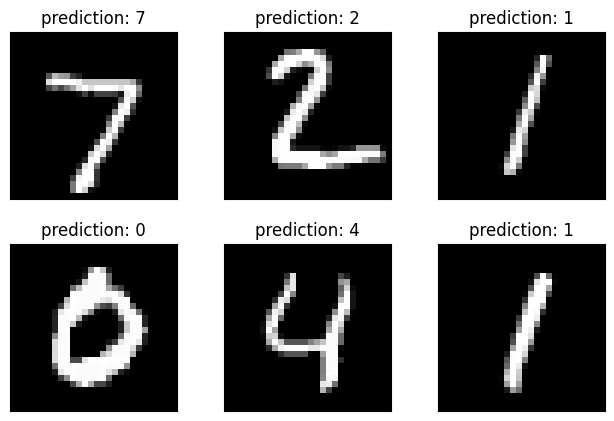

In [30]:
from matplotlib import pyplot as plt
data, labels = next(iter(test_loader))
with torch.no_grad():
  output = model(data)
  fig = plt.figure()
  for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(torch.squeeze(data[i][0]), cmap='gray', interpolation='none')
    plt.title('prediction: {}'. format(
        output.data.max(1, keepdim=True)[1][i].item()
    ))
    plt.xticks([])
    plt.yticks([])